# Plotter examples

In [1]:
import sys

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/My Drive/'
except:
    main_path = ''
sys.path.append(main_path)

In [49]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import math
import plotter
import booster
import pickle
import xgboost as xgb

In [3]:
def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [4]:
file = uproot.open("root_files/trkana-mc.root")
trkananeg = file["TrkAnaNeg"]["trkana"]

df = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
df["is_triggered"] = (df["trigbits"].values & 0x208) > 0
df["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                       if index>=0 else 0 
                                       for index, twstart in zip(df["bestcrv"], df["crvinfo__timeWindowStart"])]
df["is_signal"] = (df["demcgen_gen"] == 43) | (df["demcgen_gen"] == 2)

In [5]:
# Load the BDT and calculate the BDT score for each event

features = booster.variables.copy()
features.remove("is_signal")

for label, bkg_query in zip(booster.labels, booster.bkg_queries):
    with open(main_path+'pickles/booster_%s.pickle' % label, 'rb') as booster_file:
        booster_model = pickle.load(booster_file)
        df[label+"_score"] = booster_model.predict(
            xgb.DMatrix(df[features]),
            ntree_limit=booster_model.best_iteration)

In [6]:
samples = {'mc': df}
weights = {'mc': 1}

In [7]:
# From https://mu2e-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=28848
cuts = [
    "de_status > 0",
    "de_t0 > 700",
    "de_t0 < 1695",
    "deent_td > 0.577350",
    "deent_td < 1.000",
    "deent_d0 < 105",
    "(deent_d0 + 2./deent_om) > 450",
    "(deent_d0 + 2./deent_om) < 680",
    "dequal_TrkQual > 0.5",
    "dequal_TrkPID > 0.95",
    "ue_status <= 0",
    "deent_mom > 95",
    "(bestcrv < 0 | ((-de_t0 + crvinfo__timeWindowStart_best) > 50 | (de_t0-crvinfo__timeWindowStart_best) > 150.0))",
    "is_triggered"
]

cut = " & ".join(cuts)

In [36]:
my_plotter = plotter.Plotter(samples, weights)

## Different categorizations
The plot can be categorized according to the PDG code or according to the GenID code.

(0.5, 1000000.0)

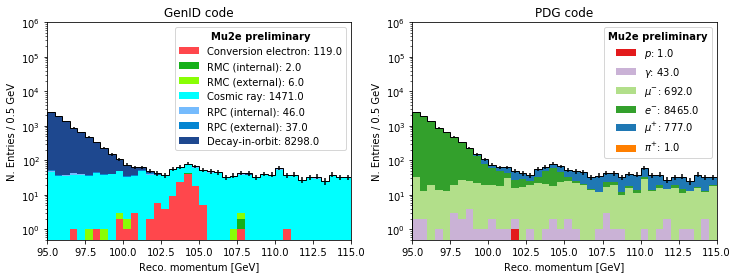

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

my_plotter.plot_variable(ax[0],
                         "deent_mom",
                         title="Reco. momentum [GeV]",
                         cat_var="demcgen_gen",
                         x_range=(95,115),
                         bins=40)

my_plotter.plot_variable(ax[1],
                         "deent_mom",
                         title="Reco. momentum [GeV]",
                         cat_var="demcgen_pdg",
                         x_range=(95,115),
                         bins=40)

ax[0].set_yscale('log')
ax[0].set_ylim(bottom=0.5, top=1e6)
ax[0].set_title('GenID code')
ax[1].set_yscale('log')
ax[1].set_title('PDG code')
ax[1].set_ylim(bottom=0.5, top=1e6)

## BDT score plot
Plot of the cosmic-ray and decay-in-orbit BDT scores categorized by particle GenID.

(0.5, 34812.0)

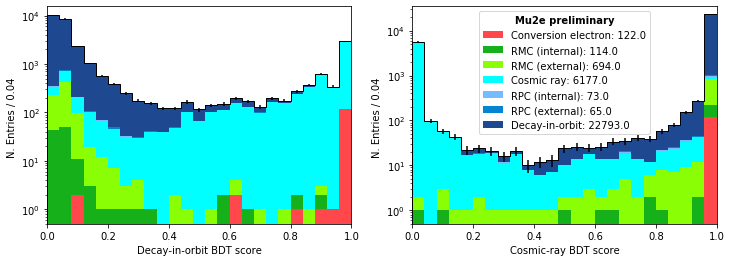

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

my_plotter.plot_variable(ax[0],
                         "dio_score",
                         title="Decay-in-orbit BDT score",
                         cat_var="demcgen_gen",
                         x_range=(0,1),
                         bins=25)

my_plotter.plot_variable(ax[1],
                         "cr_score",
                         title="Cosmic-ray BDT score",
                         cat_var="demcgen_gen",
                         x_range=(0,1),
                         bins=25)
ax[0].get_legend().remove()
ax[0].set_yscale("log")
ax[0].set_ylim(bottom=0.5)
ax[1].set_yscale("log")
ax[1].set_ylim(bottom=0.5)

## Box cuts vs. BDT

Comparison between box cuts (from https://mu2e-docdb.fnal.gov/cgi-bin/private/ShowDocument?docid=28848) and BDT using the same variables trained agains DIOs and cosmic rays.

(0.5, 200.0)

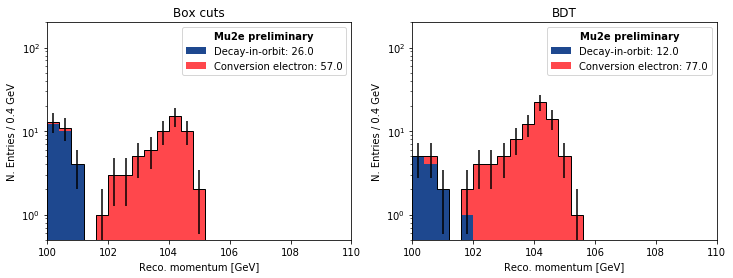

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

my_plotter.plot_variable(ax[0],
                         "deent_mom",
                         query=cut,
                         title="Reco. momentum [GeV]",
                         cat_var="demcgen_gen",
                         x_range=(100,110),
                         bins=25)

my_plotter.plot_variable(ax[1],
                         "deent_mom",
                         query="cr_score > 0.999 & dio_score > 0.95 & de_t0 > 700",
                         title="Reco. momentum [GeV]",
                         cat_var="demcgen_gen",
                         x_range=(100,110),
                         bins=25)

ax[0].set_yscale('log')
ax[0].set_ylim(bottom=0.5, top=2e2)
ax[0].set_title('Box cuts')

ax[1].set_yscale('log')
ax[1].set_title('BDT')
ax[1].set_ylim(bottom=0.5, top=2e2)